In [1]:
import numpy as np 
import keras 
from keras.datasets import mnist 
from keras.models import Model 
from keras.layers import Dense, Input
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten 
from keras import backend as k 

Using TensorFlow backend.



The MNIST dataset is an acronym that stands for the Modified National Institute of Standards and Technology dataset.

It is a dataset of 60,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

In [2]:
(x_train, y_train), (x_test, y_test) =mnist.load_data() 

plot of the first nine images in the training dataset.

In [3]:
from matplotlib import pyplot

image data format(channel is first or last):channels_last
Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


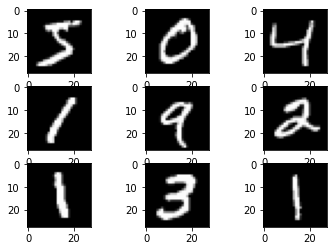

In [4]:
# summarize loaded dataset
print('image data format(channel is first or last):%s' %k.image_data_format())
print('Train: X=%s, y=%s' % (x_train.shape, y_train.shape))
print('Test: X=%s, y=%s' % (x_test.shape, y_test.shape))
# plot first few images
for i in range(9):
# define subplot
    pyplot.subplot(3,3, i+1)
# plot raw pixel data
    pyplot.imshow(x_train[i], cmap=pyplot.get_cmap('gray'))
# show the figure
pyplot.show()

In [5]:
img_rows,img_cols=28,28
# reshape dataset to have a single channel
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1) 
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1) 
inpx = (img_rows, img_cols, 1) 

In [6]:
#  convert from integers to floats then normalize to range 0-1
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32') 
x_train /= 255
x_test /= 255

In [8]:
# one hot encode target values
y_train = keras.utils.to_categorical(y_train) 
y_test = keras.utils.to_categorical(y_test)

In [9]:
y_train[1]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

The model has two main aspects: the feature extraction front end comprised of convolutional and pooling layers, and the classifier backend that will make a prediction.

In [10]:
inpx = Input(shape=inpx) 
layer1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inpx) 
layer2 = Conv2D(64, (3, 3), activation='relu')(layer1) 
layer3 = MaxPooling2D(pool_size=(3, 3))(layer2) 
layer4 = Dropout(0.5)(layer3) 
layer5 = Flatten()(layer4) 
layer6 = Dense(250, activation='sigmoid')(layer5) 
layer7 = Dense(10, activation='softmax')(layer6) 

In [11]:
model = Model(inpx, layer7) 

In [12]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               1024

In [15]:
from sklearn.model_selection import KFold
# prepare cross validation
scores, losses,histories = list(), list(), list()
n_folds=5
kfold = KFold(n_folds, shuffle=True, random_state=1)
# enumerate splits
for train_ix, valid_ix in kfold.split(x_train):
    # select rows for train and test
    train_X, train_Y, valid_X, valid_Y = x_train[train_ix], y_train[train_ix], x_train[valid_ix], y_train[valid_ix]
    # fit model
    model.compile(optimizer=keras.optimizers.Adadelta(), loss=keras.losses.categorical_crossentropy, metrics=['accuracy']) 
    history = model.fit(train_X, train_Y, epochs=15, batch_size=128, validation_data=(valid_X, valid_Y), verbose=0)
    # evaluate model
    loss, acc = model.evaluate(valid_X, valid_Y, verbose=0)
    print('> %.3f' % (acc * 100.0))
    # stores scores
    scores.append(acc)
    losses.append(loss)
    histories.append(history)

> 98.925
> 99.667
> 99.867
> 99.983
> 100.000


In [16]:
final_scores = model.evaluate(x_test, y_test, verbose=0) 
print('loss=', final_scores[0]) 
print('accuracy=', final_scores[1]) 

loss= 0.023622555063738674
accuracy= 0.9929999709129333


In [67]:
# plot diagnostic learning curves
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        pyplot.figure(linewidth=5,edgecolor="#04253a")
        pyplot.subplot(3, 1, 1)
        pyplot.title('Cross Entropy Loss _fold#%.0f'%(i+1))
        pyplot.plot(histories[i].history['loss'], color='blue', label='train_loss')
        pyplot.plot(histories[i].history['val_loss'], color='orange', label='valid_loss')
        pyplot.legend()

        # plot accuracy
        pyplot.subplot(3, 1, 3)
        pyplot.title('Classification Accuracy_fold#%.0f'%(i+1))
        pyplot.plot(histories[i].history['accuracy'], color='blue', label='train_acc')
        pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test_acc')
        pyplot.legend()
    pyplot.show()


In [24]:
from numpy import mean
from numpy import std    
    # summarize model performance
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
    # box and whisker plots of results
    pyplot.boxplot(scores)
    pyplot.show()

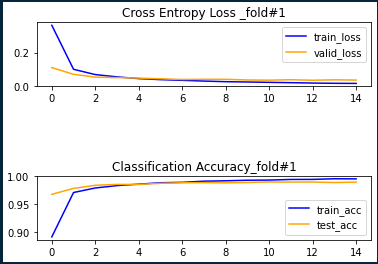

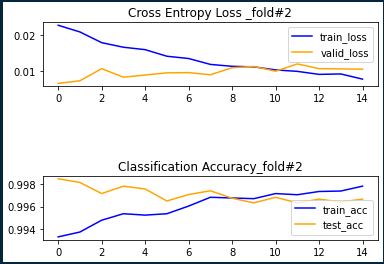

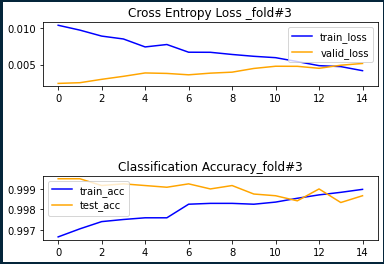

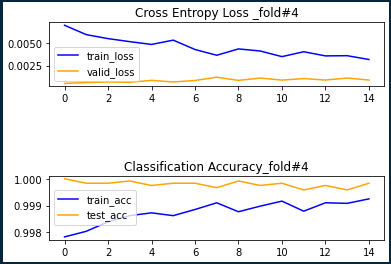

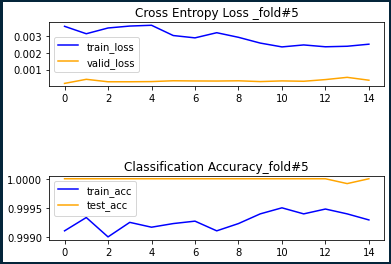

In [68]:
summarize_diagnostics(histories)

Accuracy: mean=99.688 std=0.400, n=5


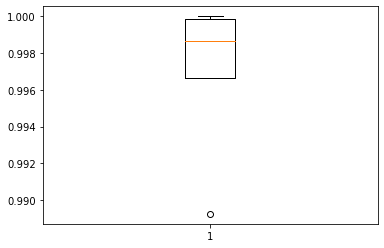

In [25]:
summarize_performance(scores)

In [26]:
# save model
model.save('final_model.h5')

In [74]:

# make a prediction for a new image.
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
 
# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, color_mode = "grayscale", target_size=(28, 28))
    # convert to array
    img = img_to_array(img)
    pyplot.imshow(img)
    # reshape into a single sample with 1 channel
    img = img.reshape(1, 28, 28, 1)
    # prepare pixel data
    img = img.astype('float32')
    img = img / 255.0
    return img
 
# load an image and predict the class 
def run_example(filename):
    # load the image
    img = load_image(filename) 
    # load model
    model = load_model('final_model.h5')
    # predict the class
    digit = model.predict(img)
    print(digit)
    return digit
    


[[4.8685797e-14 3.2482978e-11 1.7736654e-10 1.0000000e+00 1.7362073e-14
  6.5717787e-10 4.1755250e-17 6.7034628e-11 4.4670195e-11 1.3728253e-09]]


array([3], dtype=int64)

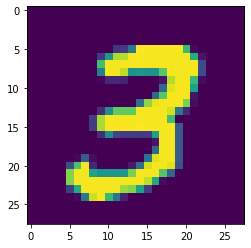

In [75]:
# entry point, run the example

np.argmax(run_example('num3.png'),axis=1)